In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from PIL import Image
from torchvision import models, transforms

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Define class labels (adjust based on your dataset)
class_labels = ["Low Corrosion", "Moderate Corrosion", "Severe Corrosion"]

# Load the trained fine-tuned model
model_path = "model/efficientnet_b0_finetuned.pth"
from torchvision.models import efficientnet_b0

# ✅ Load same model structure used during training
fine_tuned_model = efficientnet_b0(weights=None)

# ✅ Match the classifier layer used during training
in_features = fine_tuned_model.classifier[1].in_features
fine_tuned_model.classifier[1] = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(in_features, len(class_labels))
)

# ✅ Load model weights
fine_tuned_model.load_state_dict(torch.load(model_path, map_location=device))
fine_tuned_model = fine_tuned_model.to(device)
fine_tuned_model.eval()

# Define image preprocessing (must match training preprocessing)
image_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to 3 channels
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


# ✅ Function to Predict a Single Image
def predict_image(image_path):
    image = Image.open(image_path).convert("RGB")  # Keep as RGB (3 channels)
    image = image_transform(image).unsqueeze(0).to(device)  # Add batch dimension

    with torch.no_grad():
        output = fine_tuned_model(image)
        _, predicted_class = output.max(1)

    predicted_label = class_labels[predicted_class.item()]

    # Display the image and prediction
    img = Image.open(image_path)
    plt.imshow(img, cmap="gray")
    plt.title(f"Predicted: {predicted_label}")
    plt.axis("off")
    plt.show()

    print(f"Predicted Class: {predicted_label}")


# ✅ Function to Generate Grad-CAM Visualization
def generate_gradcam(image_path, model, target_layer="layer4"):
    """
    Generate Grad-CAM heatmap for model explainability.
    """
    model.eval()

    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    image_tensor = image_transform(image).unsqueeze(0).to(device)

    # Ensure CUDA context is set before forward pass
    _ = model(torch.zeros((1, 3, 224, 224), device=device))

    # Initialize storage for activations & gradients
    activations = []
    gradients = []

    # Define forward and backward hooks
    def forward_hook(module, input, output):
        activations.append(output)

    def backward_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0])

    # Attach hooks to the correct layer
    for name, module in model.named_modules():
        if name == target_layer:
            module.register_forward_hook(forward_hook)
            module.register_full_backward_hook(backward_hook)

    # **Forward pass**
    outputs = model(image_tensor)
    _, predicted_class = outputs.max(1)

    # **Ensure hook captured activations**
    if not activations:
        print(f"Error: No activations captured for layer '{target_layer}'. Check layer name.")
        return

    activation = activations[0]

    # **Backward pass to get gradients**
    model.zero_grad()
    one_hot_output = torch.zeros_like(outputs).to(device)
    one_hot_output[0, predicted_class] = 1
    outputs.backward(gradient=one_hot_output)

    # **Ensure hook captured gradients**
    if not gradients:
        print(f"Error: No gradients captured for layer '{target_layer}'. Check layer name.")
        return

    gradient = gradients[0]

    # Compute Grad-CAM heatmap
    pooled_gradients = torch.mean(gradient, dim=[0, 2, 3])
    for i in range(activation.shape[1]):
        activation[:, i, :, :] *= pooled_gradients[i]

    heatmap = torch.mean(activation, dim=1).squeeze().detach().cpu().numpy()
    heatmap = np.maximum(heatmap, 0)  # Apply ReLU
    heatmap /= np.max(heatmap)  # Normalize

    # Convert heatmap to image
    heatmap = cv2.resize(heatmap, (224, 224))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Load original image
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))

    # Overlay heatmap on image
    overlay = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    # Show images
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.title(f"Grad-CAM: {class_labels[predicted_class.item()]}")
    plt.axis("off")

    plt.show()
    print(f"Predicted Class: {class_labels[predicted_class.item()]}")


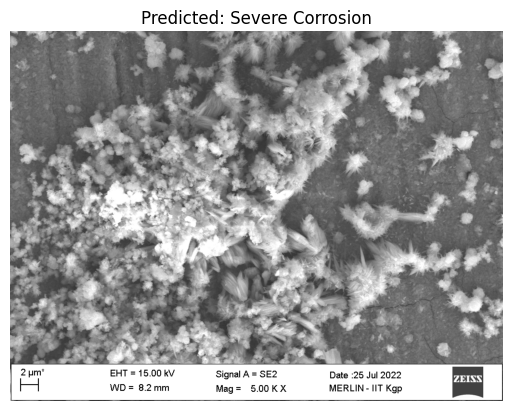

Predicted Class: Severe Corrosion


C:\Users\Kyojuro\MLProjects\SEMClassify\.venv\Lib\site-packages\torch\autograd\graph.py:824: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:181.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


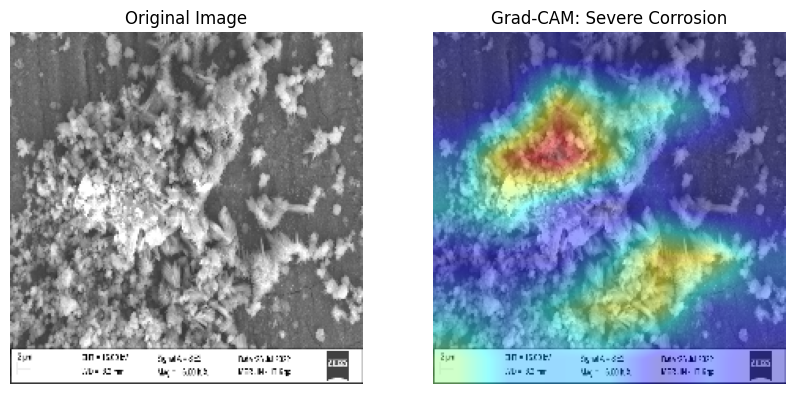

Predicted Class: Severe Corrosion


In [7]:
sample_image_path = "dataset/an_180/7days/Img_Slide12_No5.png"
predict_image(sample_image_path)
generate_gradcam(sample_image_path, fine_tuned_model, target_layer="features.8")